## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [1]:
from get_data import unpack
from pathlib import Path
cur_dir = Path('.').absolute()
data_dir = cur_dir.joinpath('data')
if not data_dir.is_dir():
    unpack('data.tar.xz', cur_dir)
else:
    print('"data" is already unpacked')

"data" is already unpacked


Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [2]:
import random
import numpy as np
import pandas as pd
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm_notebook
import gc

In [3]:
random.seed(123)
np.random.seed(123)

In [4]:
def get_imgs(dirname):
    """
    Obtain images from dirname
    
    Parameters
    ----------
    dirname : Path or str
        The directory to obtain the images from
    
    Returns
    -------
    imgs : np.array, shape (N, 100, 100, 3)
        The N images in the dirname directory
    orig_width : np.array, shape (N,)
        The original widths of the images
    orig_height : np.array, shape (N,)
        The original heights of the images
    """
    
    # Sorting to let the filename correspond with points
    img_paths = sorted(dirname.glob('**/*.jpg'))
    n_imgs = len(img_paths)
    size = 100
    
    # Define the shape of imgs
    imgs = np.zeros((n_imgs, size, size, 3))
    orig_width = np.zeros(n_imgs)
    orig_height = np.zeros(n_imgs)
    
    for nr, img_path in enumerate(tqdm_notebook(img_paths)):
        img = imread(img_path)
        # Ensure 3 channels
        if len(img.shape) == 2:
            img = gray2rgb(img)
            
        # Store width and height
        orig_width[nr] = img.shape[0]
        orig_height[nr] = img.shape[1]
        
        # Resize and store
        img = resize(img, (size, size), mode='reflect', anti_aliasing=True)
        imgs[nr, :, :, :] = img
        
    return imgs, orig_width, orig_height

In [5]:
def get_points(dirname, orig_width, orig_height):
    """
    Obtain points from dirname
    
    Parameters
    ----------
    dirname : Path or str
        The directory to obtain the points from
    
    Returns
    -------
    points : np.array, shape (N, 28)
        Keypoints belonging to corresponding images
    orig_width : np.array, shape (N,)
        The original widths of the images
    orig_height : np.array, shape (N,)
        The original heights of the images
    """
    
    csv_path = data_dir.joinpath('gt.csv')
    points_df = pd.read_csv(csv_path)
    # NOTE: The filename is sorted in the same manner as imgs are
    # NOTE: Casting to float to use the /= operator
    points = points_df.loc[:, [col for col in points_df.columns if col != 'filename']].values.astype(float)

    # Normalize
    for i in tqdm_notebook(range(points.shape[0])):
        # NOTE: The columns are arranged like the following
        #       x1 y1 x2 x2 ... x14 y14
        # Normalize width (the xs) by taking every second column
        points[i, ::2] /= orig_width[i]
        # Normalize height (the ys) by taking every second column starting from 1
        points[i, 1::2] /= orig_height[i]
    
    # Scale to [-0.5, 0.5]
    points -= 0.5
    
    return points

In [6]:
def load_imgs_and_keypoints(dirname=cur_dir.joinpath('data')):
    """
    Loads the images and keypoints
    
    Parameters
    ----------
    dirname : Path or str
        The directory to obtain the data from
    
    Returns
    -------
    imgs : np.array, shape (N, 100, 100, 3)
        The N images in the dirname directory
    points : np.array, shape (N, 28)
        Keypoints belonging to imgs
    """
    
    imgs, orig_width, orig_height = get_imgs(dirname)
    points = get_points(dirname, orig_width, orig_height)

    return imgs, points

imgs, points = load_imgs_and_keypoints()

In [7]:
print(f'Max {points.max():.2f} found at image {np.where(np.isclose(points, points.max()))[0][0]}')
print(f'Min {points.min():.2f} found at image {np.where(np.isclose(points, points.min()))[0][0]}')

Max 0.68 found at image 519
Min -0.60 found at image 1483


> **NOTE**: By inspecting the images with the max and the min, we indeed find that these points are outside the frame.

array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

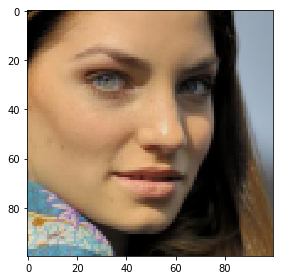

In [8]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

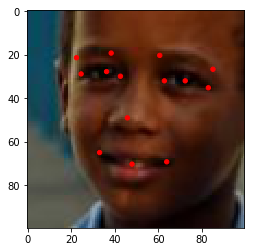

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_points(img, points):
    """
    Visualizes the points on the image
    
    Parameters
    ----------
    img : np.array, shape (cols, rows)
        The image
    points : np.array, shape (28)
        The points given like x1 y1 x2 y2 ... x14 y14
    """
    # Make point pairs
    point_pairs = list(zip(points[::2], points[1::2]))
    
    fig, ax = plt.subplots()
    # Plot the image
    ax.imshow(img)
    # Plot the points
    for x, y in point_pairs:
        # Backtransform
        x = (x+0.5)*100
        y = (y+0.5)*100
        # Plot
        circle = plt.Circle((x, y), radius=1, color='r')
        ax.add_artist(circle)
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [10]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). Visualize an example of original and flipped image.

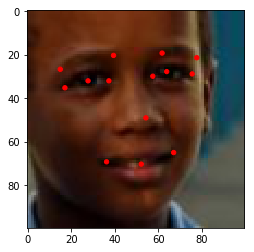

In [11]:
def flip_img(img, points):
    """
    Flips and image and its points
    
    Parameters
    ----------
    img : np.array, shape (100, 100)
        The image to flip
    points : np.array, shape (28)
        The points given like x1 y1 x2 y2 ... x14 y14
        
    Returns
    -------
    f_img : np.array, shape (100, 100)
        The flipped image
    f_points : np.array, shape (100, 100)
        The flipped points given like x1 y1 x2 y2 ... x14 y14
    """
    
    # Flip the image
    f_img = img.copy()
    # Flipping the x-axis will simply be to reverse the column order
    # NOTE: We use ellipsis to have arbitrary numbers of first dimensions
    # https://stackoverflow.com/questions/772124/what-does-the-python-ellipsis-object-do
    f_img = f_img[..., ::-1, :]
    
    # Flip the points along the x-axis by negating the x coordinate
    f_points = points.copy()
    # NOTE: We use ellipsis to have arbitrary numbers of first dimensions
    f_points[..., ::2] = -f_points[..., ::2] 
    
    return f_img, f_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [12]:
aug_imgs_train, aug_points_train = flip_img(imgs_train, points_train)

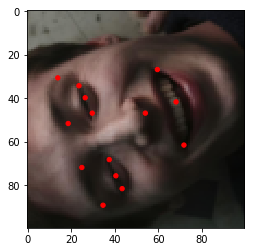

In [13]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

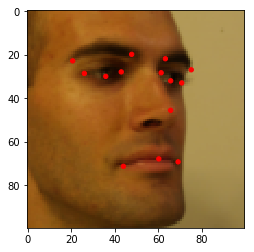

In [14]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

In [15]:
# Make training data and validation data
x_train = np.concatenate((imgs_train, aug_imgs_train), axis=0)/255
x_val = imgs_val/255

In [16]:
y_train = np.concatenate((points_train, aug_points_train), axis=0)
y_val = points_val

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [17]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras import regularizers

Using TensorFlow backend.


In [18]:
def compile_model(model, loss='mse', optimizer='adadelta'):
    """
    Compiles the model
    
    Parameters
    ----------
    model : Sequential
        The uncompiled model
    loss : str or function
        The loss function
    optimizer : str or keras.optimizer
        The optimizer
    
    Returns
    -------
    model : Sequential
        The compiled model
    """
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['mse'])

    return model

In [89]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import pickle

def fit_model(model,
              name,
              x_train_=x_train,
              y_train_=y_train,
              x_val_=x_val,
              y_val_=y_val,
              patience=7,
              batch_size=64,
              epochs=100,
              additional_callbacks=None):
    """
    Fits the model
    
    Notes
    -----
    x_train, y_train, x_val and y_val must be global variables
    
    Parameters
    ----------
    model : Sequential
        The compiled model
    name : str
        Name of the model
    x_train_ : array-like
        The training data
    y_train_ :array-like
        The target data for training
    x_val_ : array-like
        The validation data
    y_val_ :array-like
        The target data for validation
    patience : int
        How long to wait for non-imporving validation error
    batch_size : int
        The batch size
    epochs : int
        Number of epochs
    additional_callbacks : list
        List of additional callbacks
    
    Returns
    -------
    model : Sequential
        The fitted model
    history : dict
        The history of the fit
    """
    
    model_dir = Path('.').absolute().joinpath('models')
    model_dir.mkdir(exist_ok=True)
    model_path = model_dir.joinpath(f'{name}.h5')
    history_path = model_dir.joinpath(f'{name}.pickle')
    
    if not model_path.is_file():
        stopper = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto', baseline=None)
        checkpointer = ModelCheckpoint(filepath=str(model_path),
                                       verbose=1, 
                                       save_best_only=True)
        if additional_callbacks is not None:
            callbacks = [checkpointer, stopper]
        else:
            callbacks = [checkpointer, stopper, *additional_callbacks]
            
        history = model.fit(x_train_,
                            y_train_,
                            validation_data=(x_val_, y_val_),
                            batch_size=64,
                            epochs=100,
                            shuffle=True,
                            callbacks=callbacks)
        
        history = history.history
        with history_path.open('wb') as f:
            pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)  
    else:
        model = load_model(str(model_path))
        with history_path.open('rb') as f:
            history = pickle.load(f)
    return model, history

In [20]:
def plot_history(history):
    """
    Plots the history
    
    Parameters
    ----------
    history : history
        The history of the fit
        
    Returns
    -------
    best_val_mse : float
        The best validation mse
    """
    
    fig, ax = plt.subplots()
    
    # NOTE: When regularizers are used, the loss is no longer the same as mse
    ax.plot(history['mean_squared_error'], label='train_mse')
    ax.plot(history['val_mean_squared_error'], label='val_mse')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Mean squared error')
    ax.set_yscale('log')
    ax.grid(True)
    _ = ax.legend(loc='lower left')
    
    best_val_mse = np.array(history['val_mean_squared_error']).min()
    
    return best_val_mse

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [21]:
def lenet(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet-like model
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=20,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=50,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(dropout))
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [22]:
def alexnet(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled alexnet-like model
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=96,
                     kernel_size=11,
                     strides=4,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=3, 
                           strides=2))
    
    model.add(Conv2D(filters=256,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=3,
                           strides=2))
    
    model.add(Conv2D(filters=384,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(Conv2D(filters=384,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(Conv2D(filters=256,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=3,
                           strides=2))
    
    model.add(Flatten())
    
    model.add(Dense(9216, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout))

    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [23]:
def lenet_double(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet-like with more pooling and more fully connected layers
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=20,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=50,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=120,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(800, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(dropout))
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [24]:
def lenet_double_batch_normalization(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_double, but with batch normalization
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=20,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=50,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=120,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(800, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [25]:
def lenet_double_bn_leaky(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_double_batch_normalization, but with leaky ReLU activation
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=20,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=50,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=120,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(800))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(500))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [26]:
def lenet_d_bn_l_more_filters(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_double_bn_leaky, but with more filters
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=256,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(800))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(500))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [27]:
def lenet_d_bn_l_more_filters_reg(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_d_bn_l_more_filters, but with regularization in the last layer
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=256,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(800))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(500))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, 
                    activation='linear',
                    kernel_regularizer=regularizers.l2(0.01),
                    activity_regularizer=regularizers.l1(0.01)))
    
    model.summary()
    
    return model

In [28]:
def lenet_d_bn_l_more_filters_less_fc(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_d_bn_l_more_filters, but with less nodes in the second last fc layer
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=256,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(400))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(500))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [29]:
def lenet_d_bn_l_mf_2(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_d_bn_l_more_filters, but with more filters
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=128,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=512,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(800))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(500))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [30]:
def lenet_pow_2(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_d_bn_l_more_filters, but nodes increasing by the power of 2
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=128,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [31]:
def lenet_pow_2_k_4(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_pow_2, but with kernel size of 4
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=128,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [32]:
def lenet_pow_2_k_4_a_1(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_pow_2_k_4, but with alpha=0.1 in the leaky ReLU activations
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=128,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [33]:
def lenet_pow_2_k_4_double_one(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_pow_2_k_4, but with kernel size of 4
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=128,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [34]:
def lenet_pow_2_k_4_double_all(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_pow_2_k_4, but with kernel size of 4
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=128,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [35]:
def lenet_pow_2_k_4_large_fc(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_pow_2_k_4, but with large fully connectors
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=128,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(1000))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(1000))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [36]:
def lenet_pow_2_k_4_swapped(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_pow_2_k_4, but with the numbers of the last layers swapped
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=128,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [37]:
def lenet_pow_2_k_4_no_bn_no_leaky(input_shape, dropout=0.3, outputs=28):
    """
    Returns an uncompiled lenet_pow_2_k_4, but without batch normalization and leaky relu
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=128,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout))

    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

In [77]:
def lenet_pow_2_k_4_no_bn_no_leaky_2_do(input_shape, dropout_1=0.5, dropout_2=0.1, outputs=28):
    """
    Returns an uncompiled lenet_pow_2_k_4_no_bn_no_leaky, but with possibility to vary 2 dropouts
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=128,
                     kernel_size=4,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_1))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_2))

    
    # NOTE: We use identity on the last layer as we are dealing with a regression problem
    model.add(Dense(outputs, activation='linear'))
    
    model.summary()
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 20)      1520      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 50)        25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 31250)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               15625500  
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
__________

5408

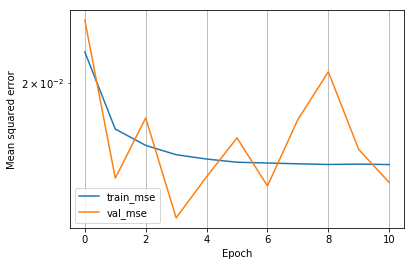

In [38]:
lenet_model = lenet(imgs_train.shape[1:])
lenet_model = compile_model(lenet_model)
lenet_model, lenet_history = fit_model(lenet_model, 'lenet')
lenet_mse = plot_history(lenet_history)
del(lenet_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 25, 25, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 384)         2457984   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 384)         3686784   
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 256)         2457856   
__________

8697

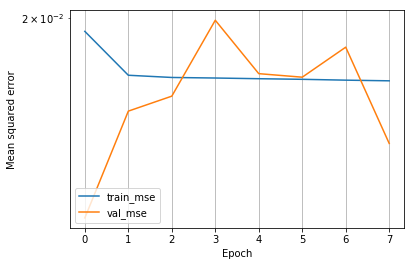

In [39]:
alexnet_model = alexnet(imgs_train.shape[1:])
alexnet_model = compile_model(alexnet_model)
alexnet_model, alexnet_history = fit_model(alexnet_model, 'alexnet')
alexnet_mse = plot_history(alexnet_history)
del(alexnet_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 20)      1520      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 50)        25050     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 50)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 120)       150120    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 120)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 17280)             0         
__________

12676

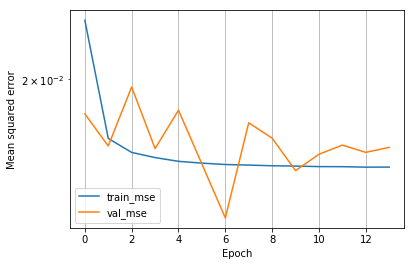

In [40]:
lenet_double_model = lenet_double(imgs_train.shape[1:])
lenet_double_model = compile_model(lenet_double_model)
lenet_double_model, lenet_double_history = fit_model(lenet_double_model, 'lenet_double')
lenet_double_mse = plot_history(lenet_double_history)
del(lenet_double_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 100, 100, 20)      1520      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 20)      80        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 50)        25050     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 50)        200       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 50)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 120)       150120    
__________

8051

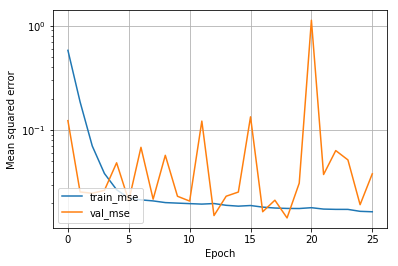

In [41]:
lenet_double_batch_normalization_model = lenet_double_batch_normalization(imgs_train.shape[1:])
lenet_double_batch_normalization_model = compile_model(lenet_double_batch_normalization_model)
lenet_double_batch_normalization_model, lenet_double_batch_normalization_history = fit_model(lenet_double_batch_normalization_model, 'lenet_double_batch_normalization')
lenet_double_batch_normalization_mse = plot_history(lenet_double_batch_normalization_history)
del(lenet_double_batch_normalization_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 100, 100, 20)      1520      
_________________________________________________________________
batch_normalization_7 (Batch (None, 100, 100, 20)      80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 50)        25050     
_________________________________________________________________
batch_normalization_8 (Batch (None, 50, 50, 50)        200       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 25, 25, 50)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 25, 120)       150120    
__________

7615

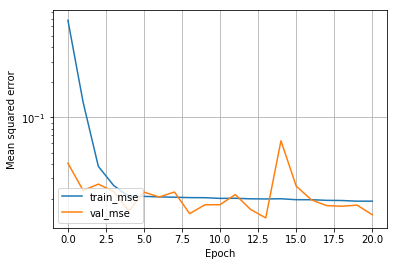

In [42]:
lenet_double_batch_norm_high_dropout_model = lenet_double_batch_normalization(imgs_train.shape[1:], dropout=0.5)
lenet_double_batch_norm_high_dropout_model = compile_model(lenet_double_batch_norm_high_dropout_model)
lenet_double_batch_norm_high_dropout_model, lenet_double_batch_norm_high_dropout_history = fit_model(lenet_double_batch_norm_high_dropout_model, 'lenet_double_batch_norm_high_dropout')
lenet_double_batch_norm_high_dropout_mse = plot_history(lenet_double_batch_norm_high_dropout_history)
del(lenet_double_batch_norm_high_dropout_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 100, 100, 20)      1520      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100, 100, 20)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 100, 100, 20)      80        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 50)        25050     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50, 50, 50)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 50, 50, 50)        200       
__________

8943

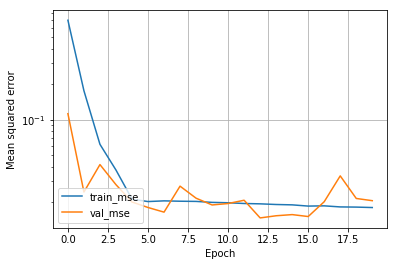

In [43]:
lenet_double_bn_leaky_high_do_model = lenet_double_bn_leaky(imgs_train.shape[1:], dropout=0.5)
lenet_double_bn_leaky_high_do_model = compile_model(lenet_double_bn_leaky_high_do_model)
lenet_double_bn_leaky_high_do_model, lenet_double_bn_leaky_high_do_history = fit_model(lenet_double_bn_leaky_high_do_model, 'lenet_bn_leaky_high_do')
lenet_double_bn_leaky_high_do_mse = plot_history(lenet_double_bn_leaky_high_do_history)
del(lenet_double_bn_leaky_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 100, 100, 32)      2432      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 50, 50, 64)        51264     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 50, 50, 64)        256       
__________

122

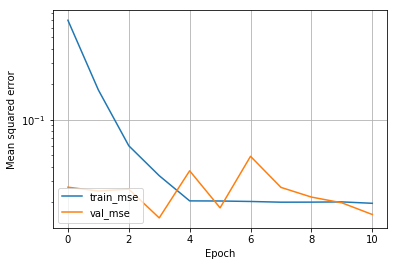

In [44]:
lenet_d_bn_l_more_filters_high_do_model = lenet_d_bn_l_more_filters(imgs_train.shape[1:], dropout=0.5)
lenet_d_bn_l_more_filters_high_do_model = compile_model(lenet_d_bn_l_more_filters_high_do_model)
lenet_d_bn_l_more_filters_high_do_model, lenet_d_bn_l_more_filters_high_do_history = fit_model(lenet_d_bn_l_more_filters_high_do_model, 'lenet_d_bn_l_more_filters_high_do')
lenet_d_bn_l_more_filters_high_do_mse = plot_history(lenet_d_bn_l_more_filters_high_do_history)
del(lenet_d_bn_l_more_filters_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 100, 100, 32)      2432      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 50, 50, 64)        51264     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 50, 50, 64)        256       
__________

38460

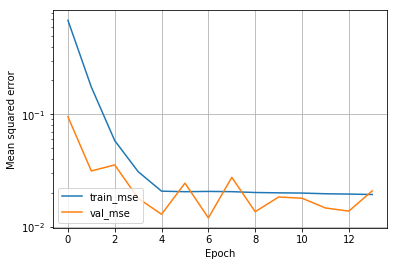

In [45]:
lenet_d_bn_l_more_filters_high_do_high_batch_model = lenet_d_bn_l_more_filters(imgs_train.shape[1:], dropout=0.5)
lenet_d_bn_l_more_filters_high_do_high_batch_model = compile_model(lenet_d_bn_l_more_filters_high_do_high_batch_model)
lenet_d_bn_l_more_filters_high_do_high_batch_model, lenet_d_bn_l_more_filters_high_do_high_batch_history = fit_model(lenet_d_bn_l_more_filters_high_do_high_batch_model, 'lenet_d_bn_l_more_filters_high_do_high_batch', batch_size=128)
lenet_d_bn_l_more_filters_high_do_high_batch_mse = plot_history(lenet_d_bn_l_more_filters_high_do_high_batch_history)
del(lenet_d_bn_l_more_filters_high_do_high_batch_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 100, 100, 32)      2432      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 50, 50, 64)        51264     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 50, 50, 64)        256       
__________

35427

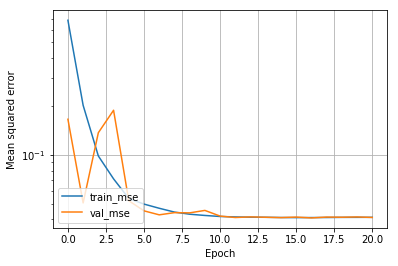

In [46]:
lenet_d_bn_l_more_filters_reg_high_do_model = lenet_d_bn_l_more_filters_reg(imgs_train.shape[1:], dropout=0.5)
lenet_d_bn_l_more_filters_reg_high_do_model = compile_model(lenet_d_bn_l_more_filters_reg_high_do_model)
lenet_d_bn_l_more_filters_reg_high_do_model, lenet_d_bn_l_more_filters_reg_high_do_history = fit_model(lenet_d_bn_l_more_filters_reg_high_do_model, 'lenet_d_bn_l_more_filters_reg_high_do')
lenet_d_bn_l_more_filters_reg_high_do_mse = plot_history(lenet_d_bn_l_more_filters_reg_high_do_history)
del(lenet_d_bn_l_more_filters_reg_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 100, 100, 32)      2432      
_________________________________________________________________
leaky_re_lu_90 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_119 (Bat (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 50, 50, 64)        51264     
_________________________________________________________________
leaky_re_lu_91 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_120 (Bat (None, 50, 50, 64)        256       
__________

84475

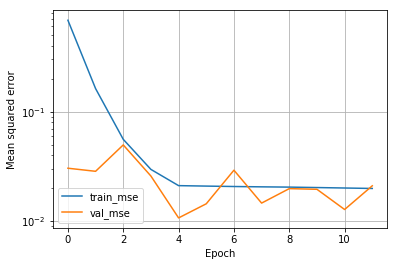

In [65]:
lenet_d_bn_l_more_filters_less_fc_high_do_model = lenet_d_bn_l_more_filters_less_fc(imgs_train.shape[1:], dropout=0.5)
lenet_d_bn_l_more_filters_less_fc_high_do_model = compile_model(lenet_d_bn_l_more_filters_less_fc_high_do_model)
lenet_d_bn_l_more_filters_less_fc_high_do_model, lenet_d_bn_l_more_filters_less_fc_high_do_history = fit_model(lenet_d_bn_l_more_filters_less_fc_high_do_model, 'lenet_d_bn_l_more_filters_less_fc_high_do')
lenet_d_bn_l_more_filters_less_fc_high_do_mse = plot_history(lenet_d_bn_l_more_filters_less_fc_high_do_history)
del(lenet_d_bn_l_more_filters_less_fc_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 100, 100, 64)      4864      
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 100, 100, 64)      0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 50, 50, 128)       204928    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 50, 50, 128)       0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 50, 50, 128)       512       
__________


Epoch 00018: val_loss did not improve from 0.01348
Epoch 00018: early stopping


25984

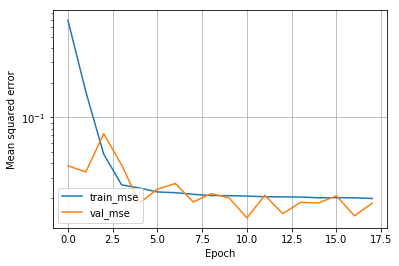

In [48]:
lenet_d_bn_l_mf_2_high_do_model = lenet_d_bn_l_mf_2(imgs_train.shape[1:], dropout=0.5)
lenet_d_bn_l_mf_2_high_do_model = compile_model(lenet_d_bn_l_mf_2_high_do_model)
lenet_d_bn_l_mf_2_high_do_model, lenet_d_bn_l_mf_2_high_do_history = fit_model(lenet_d_bn_l_mf_2_high_do_model, 'lenet_d_bn_l_mf_2_high_do')
lenet_d_bn_l_mf_2_high_do_mse = plot_history(lenet_d_bn_l_mf_2_high_do_history)
del(lenet_d_bn_l_mf_2_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 100, 100, 32)      2432      
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 50, 50, 64)        51264     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 50, 50, 64)        256       
__________


Epoch 00018: val_loss did not improve from 0.00797
Epoch 00018: early stopping


24818

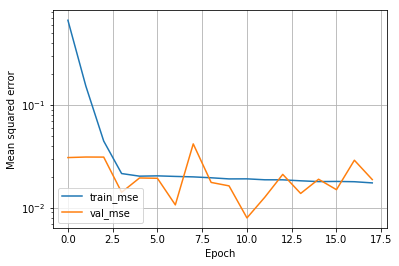

In [49]:
lenet_pow_2_high_do_model = lenet_pow_2(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_high_do_model = compile_model(lenet_pow_2_high_do_model)
lenet_pow_2_high_do_model, lenet_pow_2_high_do_history = fit_model(lenet_pow_2_high_do_model, 'lenet_pow_2_high_do')
lenet_pow_2_high_do_mse = plot_history(lenet_pow_2_high_do_history)
del(lenet_pow_2_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 50, 50, 64)        32832     
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 50, 50, 64)        256       
__________

25972

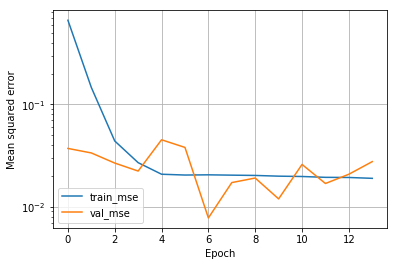

In [50]:
lenet_pow_2_k_4_high_do_model = lenet_pow_2_k_4(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_k_4_high_do_model = compile_model(lenet_pow_2_k_4_high_do_model)
lenet_pow_2_k_4_high_do_model, lenet_pow_2_k_4_high_do_history = fit_model(lenet_pow_2_k_4_high_do_model, 'lenet_pow_2_k_4_high_do')
lenet_pow_2_k_4_high_do_mse = plot_history(lenet_pow_2_k_4_high_do_history)
del(lenet_pow_2_k_4_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 50, 50, 64)        32832     
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 50, 50, 64)        256       
__________


Epoch 00017: val_loss did not improve from 0.01216
Epoch 18/100
10800/10800 [==============================] - 9s 849us/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0160 - val_mean_squared_error: 0.0160

Epoch 00018: val_loss did not improve from 0.01216
Epoch 19/100
10800/10800 [==============================] - 9s 849us/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0121 - val_mean_squared_error: 0.0121

Epoch 00019: val_loss improved from 0.01216 to 0.01209, saving model to /home/michael/coursera_advanced_machine_learning/course_5_deep_learning_in_computer_vision/week2-image_classification_image_retrieval_and_keypoint_regression/models/lenet_pow_2_k_4_a_1_high_do.h5
Epoch 20/100
10800/10800 [==============================] - 9s 847us/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0241 - val_mean_squared_error: 0.0241

Epoch 00020: val_loss did not improve from 0.01209
Epoch 21/100
10800/10800 [==============================] - 9s 85

25999

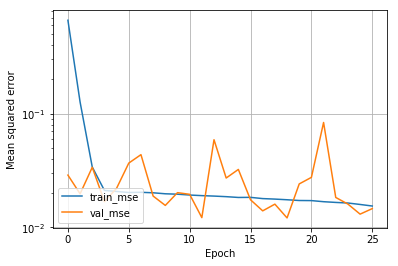

In [51]:
lenet_pow_2_k_4_a_1_high_do_model = lenet_pow_2_k_4_a_1(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_k_4_a_1_high_do_model = compile_model(lenet_pow_2_k_4_a_1_high_do_model)
lenet_pow_2_k_4_a_1_high_do_model, lenet_pow_2_k_4_a_1_high_do_history = fit_model(lenet_pow_2_k_4_a_1_high_do_model, 'lenet_pow_2_k_4_a_1_high_do')
lenet_pow_2_k_4_a_1_high_do_mse = plot_history(lenet_pow_2_k_4_a_1_high_do_history)
del(lenet_pow_2_k_4_a_1_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 100, 100, 32)      16416     
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 50, 50, 32)        0         
__________


Epoch 00014: val_loss did not improve from 0.01682
Epoch 15/100
10800/10800 [==============================] - 13s 1ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0166 - val_mean_squared_error: 0.0166

Epoch 00015: val_loss improved from 0.01682 to 0.01657, saving model to /home/michael/coursera_advanced_machine_learning/course_5_deep_learning_in_computer_vision/week2-image_classification_image_retrieval_and_keypoint_regression/models/lenet_pow_2_k_4_double_one_high_do.h5
Epoch 16/100
10800/10800 [==============================] - 13s 1ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0199 - val_mean_squared_error: 0.0199

Epoch 00016: val_loss did not improve from 0.01657
Epoch 17/100
10800/10800 [==============================] - 13s 1ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0157 - val_mean_squared_error: 0.0157

Epoch 00017: val_loss improved from 0.01657 to 0.01571, saving model to /home/michael/coursera_advanced_machine_

31219

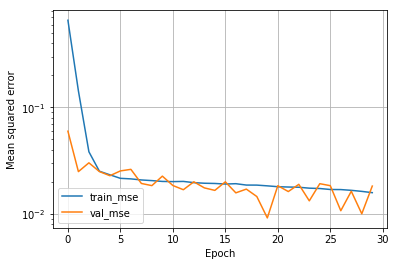

In [52]:
lenet_pow_2_k_4_double_one_high_do_model = lenet_pow_2_k_4_double_one(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_k_4_double_one_high_do_model = compile_model(lenet_pow_2_k_4_double_one_high_do_model)
lenet_pow_2_k_4_double_one_high_do_model, lenet_pow_2_k_4_double_one_high_do_history = fit_model(lenet_pow_2_k_4_double_one_high_do_model, 'lenet_pow_2_k_4_double_one_high_do', patience=10)
lenet_pow_2_k_4_double_one_high_do_mse = plot_history(lenet_pow_2_k_4_double_one_high_do_history)
del(lenet_pow_2_k_4_double_one_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 100, 100, 32)      16416     
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_75 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 50, 50, 32)        0         
__________

10800/10800 [==============================] - 16s 2ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0137 - val_mean_squared_error: 0.0137

Epoch 00012: val_loss did not improve from 0.01277
Epoch 13/100
10800/10800 [==============================] - 16s 2ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0142 - val_mean_squared_error: 0.0142

Epoch 00013: val_loss did not improve from 0.01277
Epoch 14/100
10800/10800 [==============================] - 16s 2ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0125 - val_mean_squared_error: 0.0125

Epoch 00014: val_loss improved from 0.01277 to 0.01251, saving model to /home/michael/coursera_advanced_machine_learning/course_5_deep_learning_in_computer_vision/week2-image_classification_image_retrieval_and_keypoint_regression/models/lenet_pow_2_k_4_double_all_high_do.h5
Epoch 15/100
10800/10800 [==============================] - 16s 2ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_los

42150

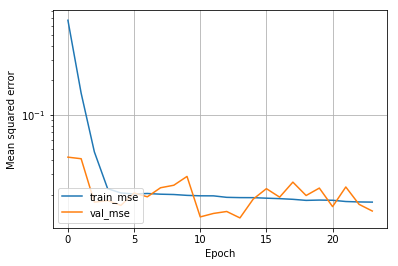

In [53]:
lenet_pow_2_k_4_double_all_high_do_model = lenet_pow_2_k_4_double_all(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_k_4_double_all_high_do_model = compile_model(lenet_pow_2_k_4_double_all_high_do_model)
lenet_pow_2_k_4_double_all_high_do_model, lenet_pow_2_k_4_double_all_high_do_history = fit_model(lenet_pow_2_k_4_double_all_high_do_model, 'lenet_pow_2_k_4_double_all_high_do', patience=10)
lenet_pow_2_k_4_double_all_high_do_mse = plot_history(lenet_pow_2_k_4_double_all_high_do_history)
del(lenet_pow_2_k_4_double_all_high_do_model)
gc.collect()

In [54]:
x_train_gray = rgb2gray(x_train)[..., np.newaxis]
x_val_gray = rgb2gray(x_val)[..., np.newaxis]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 100, 100, 32)      544       
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 50, 50, 64)        32832     
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 50, 50, 64)        256       
__________


Epoch 00017: val_loss did not improve from 0.00761
Epoch 18/100
10800/10800 [==============================] - 8s 778us/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0142 - val_mean_squared_error: 0.0142

Epoch 00018: val_loss did not improve from 0.00761
Epoch 19/100
10800/10800 [==============================] - 8s 778us/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0313 - val_mean_squared_error: 0.0313

Epoch 00019: val_loss did not improve from 0.00761
Epoch 20/100
10800/10800 [==============================] - 8s 778us/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0130 - val_mean_squared_error: 0.0130

Epoch 00020: val_loss did not improve from 0.00761
Epoch 21/100
10800/10800 [==============================] - 8s 778us/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0146 - val_mean_squared_error: 0.0146

Epoch 00021: val_loss did not improve from 0.00761
Epoch 22/100
10800/10800 [==============================] - 

25032

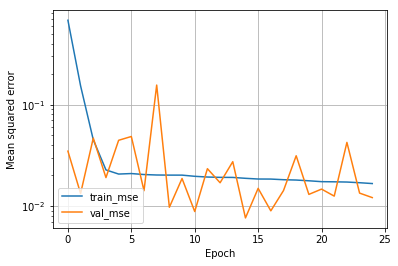

In [55]:
lenet_pow_2_k_4_high_do_gray_model = lenet_pow_2_k_4(x_train_gray.shape[1:], dropout=0.5)
lenet_pow_2_k_4_high_do_gray_model = compile_model(lenet_pow_2_k_4_high_do_gray_model)
lenet_pow_2_k_4_high_do_gray_model, lenet_pow_2_k_4_high_do_gray_history = \
    fit_model(lenet_pow_2_k_4_high_do_gray_model, 
              'lenet_pow_2_k_4_high_do_gray',
              x_train_=x_train_gray,
              x_val_=x_val_gray, 
              patience=10)
lenet_pow_2_k_4_high_do_gray_mse = plot_history(lenet_pow_2_k_4_high_do_gray_history)
del(lenet_pow_2_k_4_high_do_gray_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_89 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 50, 50, 64)        32832     
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 50, 50, 64)        256       
__________

30798

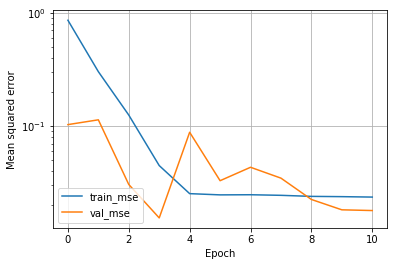

In [56]:
lenet_pow_2_k_4_large_fc_high_do_model = lenet_pow_2_k_4_large_fc(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_k_4_large_fc_high_do_model = compile_model(lenet_pow_2_k_4_large_fc_high_do_model)
lenet_pow_2_k_4_large_fc_high_do_model, lenet_pow_2_k_4_large_fc_high_do_history = fit_model(lenet_pow_2_k_4_large_fc_high_do_model, 'lenet_pow_2_k_4_large_fc_high_do')
lenet_pow_2_k_4_large_fc_high_do_mse = plot_history(lenet_pow_2_k_4_large_fc_high_do_history)
del(lenet_pow_2_k_4_large_fc_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_70 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 50, 50, 64)        32832     
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 50, 50, 64)        256       
__________

26720

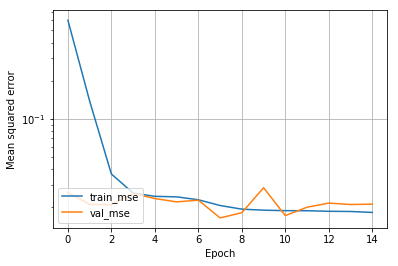

In [57]:
lenet_pow_2_k_4_swapped_high_do_model = lenet_pow_2_k_4_swapped(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_k_4_swapped_high_do_model = compile_model(lenet_pow_2_k_4_swapped_high_do_model)
lenet_pow_2_k_4_swapped_high_do_model, lenet_pow_2_k_4_swapped_high_do_history = fit_model(lenet_pow_2_k_4_swapped_high_do_model, 'lenet_pow_2_k_4_swapped_high_do')
lenet_pow_2_k_4_swapped_high_do_mse = plot_history(lenet_pow_2_k_4_swapped_high_do_history)
del(lenet_pow_2_k_4_swapped_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_75 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_101 (Bat (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 50, 50, 64)        32832     
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 50, 50, 64)        256       
__________


Epoch 00016: val_loss did not improve from 0.01785
Epoch 17/100
8400/8400 [==============================] - 8s 996us/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0223 - val_mean_squared_error: 0.0223

Epoch 00017: val_loss did not improve from 0.01785
Epoch 18/100
8400/8400 [==============================] - 8s 994us/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0170 - val_mean_squared_error: 0.0170

Epoch 00018: val_loss improved from 0.01785 to 0.01704, saving model to /home/michael/coursera_advanced_machine_learning/course_5_deep_learning_in_computer_vision/week2-image_classification_image_retrieval_and_keypoint_regression/models/lenet_pow_2_k_4_high_do_better_split.h5
Epoch 19/100
8400/8400 [==============================] - 8s 995us/step - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0174 - val_mean_squared_error: 0.0174

Epoch 00019: val_loss did not improve from 0.01704
Epoch 20/100
8400/8400 [==============================] - 8s 9

24781

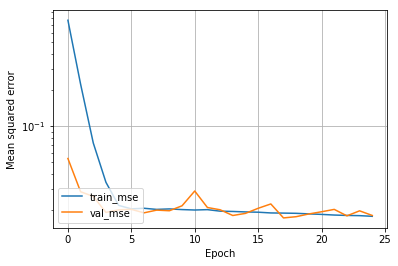

In [58]:
aug_imgs, aug_points = flip_img(imgs, points)
all_imgs = np.concatenate((imgs, aug_imgs), axis=0)/255
all_points = np.concatenate((points, aug_points), axis=0)

x_train_improved, x_val_improved, y_train_improved, y_val_improved =\
    train_test_split(all_imgs, all_points, test_size=0.3)

lenet_pow_2_k_4_high_do_better_split_model = lenet_pow_2_k_4(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_k_4_high_do_better_split_model = compile_model(lenet_pow_2_k_4_high_do_better_split_model)
lenet_pow_2_k_4_high_do_better_split_model, lenet_pow_2_k_4_high_do_better_split_history = \
    fit_model(lenet_pow_2_k_4_high_do_better_split_model, 
              'lenet_pow_2_k_4_high_do_better_split',
              x_train_=x_train_improved,
              y_train_=y_train_improved,
              x_val_=x_val_improved,
              y_val_=y_val_improved,
              patience=7)
lenet_pow_2_k_4_high_do_better_split_mse = plot_history(lenet_pow_2_k_4_high_do_better_split_history)
del(lenet_pow_2_k_4_high_do_better_split_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_107 (Bat (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 50, 50, 64)        32832     
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_108 (Bat (None, 50, 50, 64)        256       
__________

8400/8400 [==============================] - 8s 998us/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0215 - val_mean_squared_error: 0.0215

Epoch 00015: val_loss did not improve from 0.02076
Epoch 16/100
8400/8400 [==============================] - 8s 997us/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0213 - val_mean_squared_error: 0.0213

Epoch 00016: val_loss did not improve from 0.02076
Epoch 17/100
8400/8400 [==============================] - 8s 998us/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0203 - val_mean_squared_error: 0.0203

Epoch 00017: val_loss improved from 0.02076 to 0.02029, saving model to /home/michael/coursera_advanced_machine_learning/course_5_deep_learning_in_computer_vision/week2-image_classification_image_retrieval_and_keypoint_regression/models/lenet_pow_2_k_4_better_split.h5
Epoch 18/100
8400/8400 [==============================] - 8s 1ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0190 - 

25107

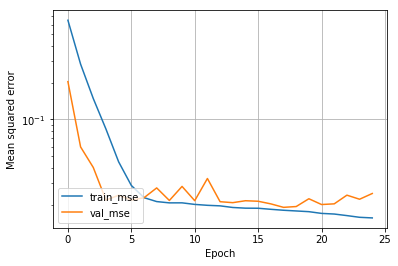

In [59]:
lenet_pow_2_k_4_better_split_model = lenet_pow_2_k_4(imgs_train.shape[1:])
lenet_pow_2_k_4_better_split_model = compile_model(lenet_pow_2_k_4_better_split_model)
lenet_pow_2_k_4_better_split_model, lenet_pow_2_k_4_better_split_history = \
    fit_model(lenet_pow_2_k_4_better_split_model, 
              'lenet_pow_2_k_4_better_split',
              x_train_=x_train_improved,
              y_train_=y_train_improved,
              x_val_=x_val_improved,
              y_val_=y_val_improved,
              patience=7)
lenet_pow_2_k_4_better_split_mse = plot_history(lenet_pow_2_k_4_better_split_history)
del(lenet_pow_2_k_4_better_split_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 50, 50, 64)        32832     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 25, 25, 128)       131200    
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 18432)             0         
__________

13520

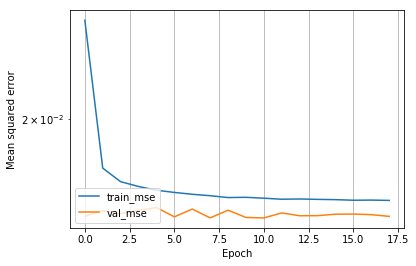

In [60]:
lenet_pow_2_k_4_better_split_no_bn_no_leaky_model = lenet_pow_2_k_4_no_bn_no_leaky(imgs_train.shape[1:])
lenet_pow_2_k_4_better_split_no_bn_no_leaky_model = compile_model(lenet_pow_2_k_4_better_split_no_bn_no_leaky_model)
lenet_pow_2_k_4_better_split_no_bn_no_leaky_model, lenet_pow_2_k_4_better_split_no_bn_no_leaky_history = \
    fit_model(lenet_pow_2_k_4_better_split_no_bn_no_leaky_model, 
              'lenet_pow_2_k_4_better_split_no_bn_no_leaky',
              x_train_=x_train_improved,
              y_train_=y_train_improved,
              x_val_=x_val_improved,
              y_val_=y_val_improved,
              patience=7)
lenet_pow_2_k_4_better_split_no_bn_no_leaky_mse = plot_history(lenet_pow_2_k_4_better_split_no_bn_no_leaky_history)
del(lenet_pow_2_k_4_better_split_no_bn_no_leaky_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_100 (LeakyReLU)  (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_131 (Bat (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 100, 100, 32)      16416     
_________________________________________________________________
leaky_re_lu_101 (LeakyReLU)  (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_132 (Bat (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 50, 50, 32)        0         
__________

10800/10800 [==============================] - 13s 1ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0141 - val_mean_squared_error: 0.0141

Epoch 00016: val_loss did not improve from 0.01114
Epoch 17/100
10800/10800 [==============================] - 13s 1ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0168 - val_mean_squared_error: 0.0168

Epoch 00017: val_loss did not improve from 0.01114
Epoch 18/100
10800/10800 [==============================] - 13s 1ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0148 - val_mean_squared_error: 0.0148

Epoch 00018: val_loss did not improve from 0.01114
Epoch 19/100
10800/10800 [==============================] - 13s 1ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0104 - val_mean_squared_error: 0.0104

Epoch 00019: val_loss improved from 0.01114 to 0.01036, saving model to /home/michael/coursera_advanced_machine_learning/course_5_deep_learning_in_computer_vision/week2-image_class

99753

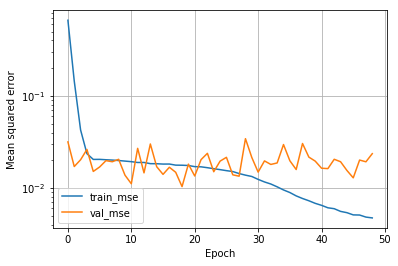

In [73]:
lenet_pow_2_k_4_d1_long_high_do_model = lenet_pow_2_k_4_double_one(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_k_4_d1_long_high_do_model = compile_model(lenet_pow_2_k_4_d1_long_high_do_model)
lenet_pow_2_k_4_d1_long_high_do_model, lenet_pow_2_k_4_d1_long_high_do_history = fit_model(lenet_pow_2_k_4_d1_long_high_do_model, 'lenet_pow_2_k_4_d1_long_high_do', patience=30)
lenet_pow_2_k_4_d1_long_high_do_mse = plot_history(lenet_pow_2_k_4_d1_long_high_do_history)
del(lenet_pow_2_k_4_d1_long_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 50, 50, 64)        32832     
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 25, 25, 128)       131200    
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 18432)             0         
__________

8400/8400 [==============================] - 5s 627us/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0189 - val_mean_squared_error: 0.0189

Epoch 00025: val_loss did not improve from 0.01877
Epoch 26/100
8400/8400 [==============================] - 5s 630us/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0188 - val_mean_squared_error: 0.0188

Epoch 00026: val_loss did not improve from 0.01877
Epoch 27/100
8400/8400 [==============================] - 5s 631us/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0188 - val_mean_squared_error: 0.0188

Epoch 00027: val_loss did not improve from 0.01877
Epoch 28/100
8400/8400 [==============================] - 5s 630us/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0188 - val_mean_squared_error: 0.0188

Epoch 00028: val_loss did not improve from 0.01877
Epoch 29/100
8400/8400 [==============================] - 5s 630us/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.018

14888

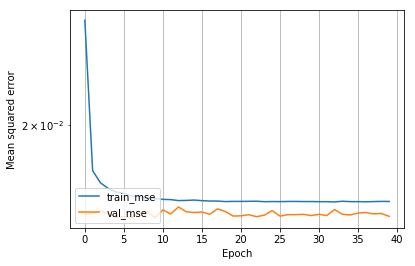

In [74]:
lenet_pow_2_k_4_better_split_no_bn_no_leaky_long_model = lenet_pow_2_k_4_no_bn_no_leaky(imgs_train.shape[1:])
lenet_pow_2_k_4_better_split_no_bn_no_leaky_long_model = compile_model(lenet_pow_2_k_4_better_split_no_bn_no_leaky_long_model)
lenet_pow_2_k_4_better_split_no_bn_no_leaky_long_model, lenet_pow_2_k_4_better_split_no_bn_no_leaky_long_history = \
    fit_model(lenet_pow_2_k_4_better_split_no_bn_no_leaky_long_model, 
              'lenet_pow_2_k_4_better_split_no_bn_no_leaky_long',
              x_train_=x_train_improved,
              y_train_=y_train_improved,
              x_val_=x_val_improved,
              y_val_=y_val_improved,
              patience=30)
lenet_pow_2_k_4_better_split_no_bn_no_leaky_long_mse = plot_history(lenet_pow_2_k_4_better_split_no_bn_no_leaky_long_history)
del(lenet_pow_2_k_4_better_split_no_bn_no_leaky_long_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 100, 100, 32)      1568      
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 50, 50, 64)        32832     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 25, 25, 128)       131200    
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 18432)             0         
__________

10800/10800 [==============================] - 6s 519us/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0192 - val_mean_squared_error: 0.0192

Epoch 00027: val_loss did not improve from 0.01861
Epoch 28/100
10800/10800 [==============================] - 6s 519us/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0192 - val_mean_squared_error: 0.0192

Epoch 00028: val_loss did not improve from 0.01861
Epoch 29/100
10800/10800 [==============================] - 6s 518us/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0191 - val_mean_squared_error: 0.0191

Epoch 00029: val_loss did not improve from 0.01861
Epoch 30/100
10800/10800 [==============================] - 6s 520us/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0191 - val_mean_squared_error: 0.0191

Epoch 00030: val_loss did not improve from 0.01861
Epoch 31/100
10800/10800 [==============================] - 6s 520us/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_l

21761

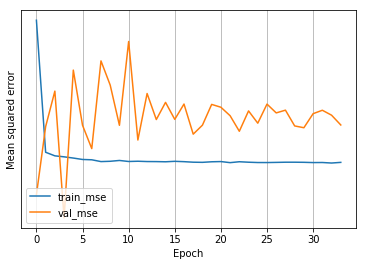

In [79]:
from keras.optimizers import Adam

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

lenet_pow_2_k_4_no_bn_no_leak_2_do_model = lenet_pow_2_k_4_no_bn_no_leaky_2_do(imgs_train.shape[1:])
lenet_pow_2_k_4_no_bn_no_leak_2_do_model = \
    compile_model(lenet_pow_2_k_4_no_bn_no_leak_2_do_model,
                  optimizer=optimizer)
lenet_pow_2_k_4_no_bn_no_leak_2_do_model, lenet_pow_2_k_4_no_bn_no_leak_2_do_history = \
    fit_model(lenet_pow_2_k_4_no_bn_no_leak_2_do_model, 
              'lenet_pow_2_k_4_no_bn_no_leak_2_do',
              patience=30)
lenet_pow_2_k_4_no_bn_no_leak_2_do_mse = plot_history(lenet_pow_2_k_4_no_bn_no_leak_2_do_history)
del(lenet_pow_2_k_4_no_bn_no_leak_2_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_121 (LeakyReLU)  (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_156 (Bat (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 50, 50, 64)        32832     
_________________________________________________________________
leaky_re_lu_122 (LeakyReLU)  (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_157 (Bat (None, 50, 50, 64)        256       
__________

10800/10800 [==============================] - 9s 877us/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0166 - val_mean_squared_error: 0.0166

Epoch 00016: val_loss did not improve from 0.01133
Epoch 17/100
10800/10800 [==============================] - 9s 875us/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0203 - val_mean_squared_error: 0.0203

Epoch 00017: val_loss did not improve from 0.01133
Epoch 18/100
10800/10800 [==============================] - 9s 875us/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0209 - val_mean_squared_error: 0.0209

Epoch 00018: val_loss did not improve from 0.01133
Epoch 19/100
10800/10800 [==============================] - 9s 874us/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0117 - val_mean_squared_error: 0.0117

Epoch 00019: val_loss did not improve from 0.01133
Epoch 20/100
10800/10800 [==============================] - 9s 875us/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_l

10800/10800 [==============================] - 9s 873us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0171 - val_mean_squared_error: 0.0171

Epoch 00052: val_loss did not improve from 0.00888
Epoch 53/100
10800/10800 [==============================] - 9s 875us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0201 - val_mean_squared_error: 0.0201

Epoch 00053: val_loss did not improve from 0.00888
Epoch 54/100
10800/10800 [==============================] - 9s 871us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0203 - val_mean_squared_error: 0.0203

Epoch 00054: val_loss did not improve from 0.00888
Epoch 55/100
10800/10800 [==============================] - 9s 875us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0231 - val_mean_squared_error: 0.0231

Epoch 00055: val_loss did not improve from 0.00888
Epoch 56/100
10800/10800 [==============================] - 9s 874us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_l

173867

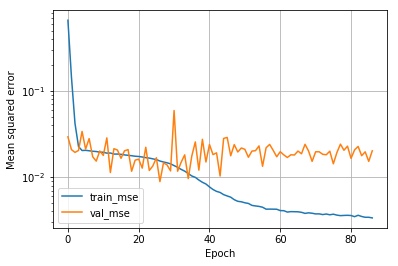

In [90]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.1,
                           patience=10, 
                           verbose=0,
                           mode='auto', 
                           min_delta=0.001, 
                           cooldown=0, 
                           min_lr=0)

lenet_pow_2_k_4_lr_red_callback_high_do_model = lenet_pow_2_k_4(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_k_4_lr_red_callback_high_do_model = compile_model(lenet_pow_2_k_4_lr_red_callback_high_do_model)
lenet_pow_2_k_4_lr_red_callback_high_do_model, lenet_pow_2_k_4_lr_red_callback_high_do_history =\
    fit_model(lenet_pow_2_k_4_lr_red_callback_high_do_model, 
              'lenet_pow_2_k_4_lr_red_callback_high_do',
              patience=60,
              additional_callbacks=[red_lr])
lenet_pow_2_k_4_lr_red_callback_high_do_mse = plot_history(lenet_pow_2_k_4_lr_red_callback_high_do_history)
del(lenet_pow_2_k_4_lr_red_callback_high_do_model)
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_131 (LeakyReLU)  (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_168 (Bat (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 50, 50, 64)        32832     
_________________________________________________________________
leaky_re_lu_132 (LeakyReLU)  (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_169 (Bat (None, 50, 50, 64)        256       
__________

5400/5400 [==============================] - 5s 901us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0028 - val_mean_squared_error: 0.0028

Epoch 00013: val_loss improved from 0.00286 to 0.00283, saving model to /home/michael/coursera_advanced_machine_learning/course_5_deep_learning_in_computer_vision/week2-image_classification_image_retrieval_and_keypoint_regression/models/lenet_pow_2_k_4_lr_red_callback_non_aug_high_do.h5
Epoch 14/100
5400/5400 [==============================] - 5s 899us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026

Epoch 00014: val_loss improved from 0.00283 to 0.00257, saving model to /home/michael/coursera_advanced_machine_learning/course_5_deep_learning_in_computer_vision/week2-image_classification_image_retrieval_and_keypoint_regression/models/lenet_pow_2_k_4_lr_red_callback_non_aug_high_do.h5
Epoch 15/100
5400/5400 [==============================] - 5s 904us/step - loss: 0.0026 - mean_squar


Epoch 00041: val_loss did not improve from 0.00196
Epoch 42/100
5400/5400 [==============================] - 5s 902us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020

Epoch 00042: val_loss did not improve from 0.00196
Epoch 43/100
5400/5400 [==============================] - 5s 901us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020

Epoch 00043: val_loss did not improve from 0.00196
Epoch 44/100
5400/5400 [==============================] - 5s 898us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0022 - val_mean_squared_error: 0.0022

Epoch 00044: val_loss did not improve from 0.00196
Epoch 45/100
5400/5400 [==============================] - 5s 899us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0030 - val_mean_squared_error: 0.0030

Epoch 00045: val_loss did not improve from 0.00196
Epoch 46/100
5400/5400 [==============================] - 5s 902us/s

5400/5400 [==============================] - 5s 903us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0018 - val_mean_squared_error: 0.0018

Epoch 00076: val_loss did not improve from 0.00180
Epoch 77/100
5400/5400 [==============================] - 5s 901us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019

Epoch 00077: val_loss did not improve from 0.00180
Epoch 78/100
5400/5400 [==============================] - 5s 900us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0021 - val_mean_squared_error: 0.0021

Epoch 00078: val_loss did not improve from 0.00180
Epoch 79/100
5400/5400 [==============================] - 5s 901us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019

Epoch 00079: val_loss did not improve from 0.00180
Epoch 80/100
5400/5400 [==============================] - 5s 904us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.001

41384

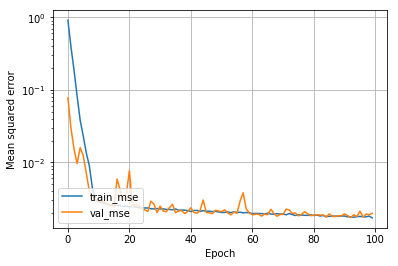

In [92]:
red_lr = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.1,
                           patience=10, 
                           verbose=0,
                           mode='auto', 
                           min_delta=0.001,
                           cooldown=0, 
                           min_lr=0)

lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_model = lenet_pow_2_k_4(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_model = compile_model(lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_model)
lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_model, lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_history =\
    fit_model(lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_model, 
              'lenet_pow_2_k_4_lr_red_callback_non_aug_high_do',
              patience=60,
              x_train_=imgs_train/255,
              y_train_=points_train,
              additional_callbacks=[red_lr])
lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_mse = plot_history(lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_history)
del(lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_model)
gc.collect()

In [98]:
results = {'lenet_mse': lenet_mse,
           'alexnet_mse': alexnet_mse,
           'lenet_double_mse': lenet_double_mse,
           'lenet_double_batch_normalization_mse': lenet_double_batch_normalization_mse,
           'lenet_double_batch_norm_high_dropout_mse': lenet_double_batch_norm_high_dropout_mse,
           'lenet_double_bn_leaky_high_do_mse': lenet_double_bn_leaky_high_do_mse,
           'lenet_d_bn_l_more_filters_high_do_mse': lenet_d_bn_l_more_filters_high_do_mse,
           'lenet_d_bn_l_more_filters_high_do_high_batch_mse': lenet_d_bn_l_more_filters_high_do_high_batch_mse,
           'lenet_d_bn_l_more_filters_reg_high_do_mse': lenet_d_bn_l_more_filters_reg_high_do_mse,
           'lenet_d_bn_l_more_filters_less_fc_high_do_mse': lenet_d_bn_l_more_filters_less_fc_high_do_mse,
           'lenet_d_bn_l_mf_2_high_do_mse': lenet_d_bn_l_mf_2_high_do_mse,
           'lenet_pow_2_high_do_mse': lenet_pow_2_high_do_mse,
           'lenet_pow_2_k_4_high_do_mse': lenet_pow_2_k_4_high_do_mse,
           'lenet_pow_2_k_4_a_1_high_do_mse': lenet_pow_2_k_4_a_1_high_do_mse,
           'lenet_pow_2_k_4_double_one_high_do_mse': lenet_pow_2_k_4_double_one_high_do_mse,
           'lenet_pow_2_k_4_double_all_high_do_mse': lenet_pow_2_k_4_double_all_high_do_mse,
           'lenet_pow_2_k_4_high_do_gray_mse': lenet_pow_2_k_4_high_do_gray_mse,
           'lenet_pow_2_k_4_large_fc_high_do_mse': lenet_pow_2_k_4_large_fc_high_do_mse,
           'lenet_pow_2_k_4_swapped_high_do_mse': lenet_pow_2_k_4_swapped_high_do_mse,
           'lenet_pow_2_k_4_high_do_better_split_mse': lenet_pow_2_k_4_high_do_better_split_mse,
           'lenet_pow_2_k_4_better_split_no_bn_no_leaky_mse': lenet_pow_2_k_4_better_split_no_bn_no_leaky_mse,
           'lenet_pow_2_k_4_d1_long_high_do_mse': lenet_pow_2_k_4_d1_long_high_do_mse,
           'lenet_pow_2_k_4_better_split_no_bn_no_leaky_long_mse': lenet_pow_2_k_4_better_split_no_bn_no_leaky_long_mse,
           'lenet_pow_2_k_4_no_bn_no_leak_2_do_mse': lenet_pow_2_k_4_no_bn_no_leak_2_do_mse,
           'lenet_pow_2_k_4_lr_red_callback_high_do_mse': lenet_pow_2_k_4_lr_red_callback_high_do_mse,
           'lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_mse': lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_mse
          }

results = dict(sorted(results.items(), key=lambda kv: kv[1]))

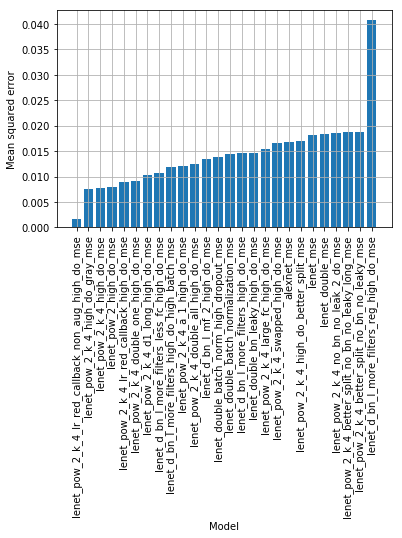

In [99]:
fig, ax = plt.subplots()
ax.bar(results.keys(), results.values())
ax.set_ylabel('Mean squared error')
ax.set_xlabel('Model')
ax.grid(True)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

> **NOTE**: It would be most appropriate to visualize on a test set as we can overfit to the validation set by trying out different architectures

In [100]:
lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_model = lenet_pow_2_k_4(imgs_train.shape[1:], dropout=0.5)
lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_model = compile_model(lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_model)
model, _ =\
    fit_model(lenet_pow_2_k_4_lr_red_callback_non_aug_high_do_model, 
              'lenet_pow_2_k_4_lr_red_callback_non_aug_high_do')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 100, 100, 32)      1568      
_________________________________________________________________
leaky_re_lu_136 (LeakyReLU)  (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_174 (Bat (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 50, 50, 64)        32832     
_________________________________________________________________
leaky_re_lu_137 (LeakyReLU)  (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_175 (Bat (None, 50, 50, 64)        256       
__________

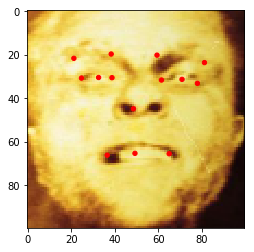

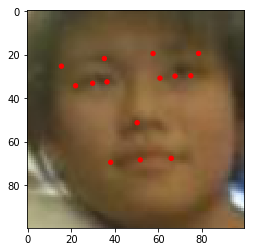

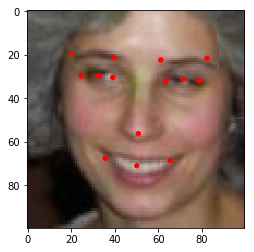

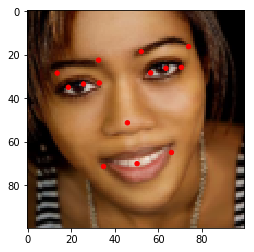

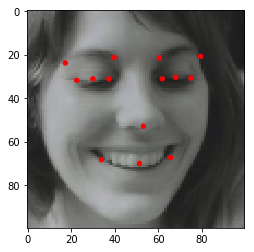

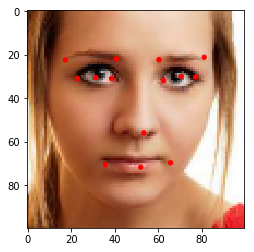

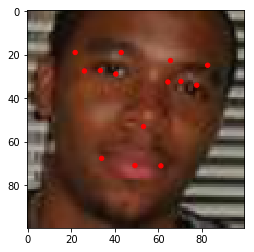

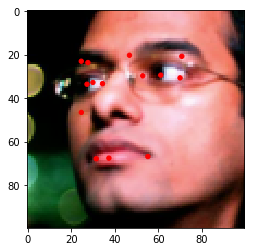

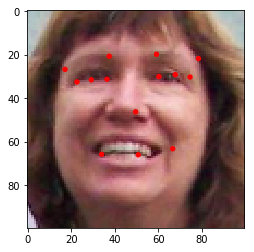

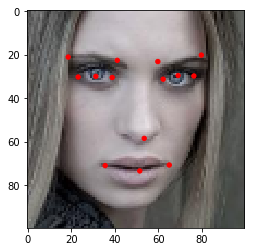

In [101]:
# Take 10 random images from the validation set
indices = random.sample(range(x_val.shape[0]), 10)

for ind in indices:
    # NOTE: We are keeping the original dimension with ind:ind+1
    predictions = model.predict(x_val[ind:ind+1, ...])[0]
    visualize_points(x_val[ind, ...]*255, predictions)